In [1]:
# Copyright 2018 Google LLC.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

# https://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# Install deps
!pip install -q -U tensor2tensor tensorflow

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import collections

from tensor2tensor import models
from tensor2tensor import problems
from tensor2tensor.layers import common_layers
from tensor2tensor.utils import trainer_lib
from tensor2tensor.utils import t2t_model
from tensor2tensor.utils import registry
from tensor2tensor.utils import metrics

# Enable TF Eager execution
from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()

# Other setup
Modes = tf.estimator.ModeKeys

# Setup some directories
data_dir = os.path.expanduser("~/t2t/data")
tmp_dir = os.path.expanduser("~/t2t/tmp")
train_dir = os.path.expanduser("~/t2t/train")
checkpoint_dir = os.path.expanduser("~/t2t/checkpoints")
tf.gfile.MakeDirs(data_dir)
tf.gfile.MakeDirs(tmp_dir)
tf.gfile.MakeDirs(train_dir)
tf.gfile.MakeDirs(checkpoint_dir)
gs_data_dir = "gs://tensor2tensor-data"
gs_ckpt_dir = "gs://tensor2tensor-checkpoints/"

# Download MNIST and inspect it

In [4]:
# A Problem is a dataset together with some fixed pre-processing.
# It could be a translation dataset with a specific tokenization,
# or an image dataset with a specific resolution.
#
# There are many problems available in Tensor2Tensor
problems.available()

['algorithmic_addition_binary40',
 'algorithmic_addition_decimal40',
 'algorithmic_cipher_shift200',
 'algorithmic_cipher_shift5',
 'algorithmic_cipher_vigenere200',
 'algorithmic_cipher_vigenere5',
 'algorithmic_identity_binary40',
 'algorithmic_identity_decimal40',
 'algorithmic_multiplication_binary40',
 'algorithmic_multiplication_decimal40',
 'algorithmic_reverse_binary40',
 'algorithmic_reverse_binary40_test',
 'algorithmic_reverse_decimal40',
 'algorithmic_reverse_nlplike32k',
 'algorithmic_reverse_nlplike8k',
 'algorithmic_shift_decimal40',
 'audio_timit_characters_tune',
 'audio_timit_tokens8k_test',
 'audio_timit_tokens8k_tune',
 'genomics_expression_cage10',
 'genomics_expression_gm12878',
 'genomics_expression_l262k',
 'gym_pong_random5k',
 'image_celeba',
 'image_cifar10',
 'image_cifar100',
 'image_cifar100_plain',
 'image_cifar100_plain8',
 'image_cifar100_plain_gen',
 'image_cifar100_tune',
 'image_cifar10_plain',
 'image_cifar10_plain8',
 'image_cifar10_plain_gen',
 'i

In [5]:
# Fetch the MNIST problem
mnist_problem = problems.problem("image_mnist")
# The generate_data method of a problem will download data and process it into
# a standard format ready for training and evaluation.
mnist_problem.generate_data(data_dir, tmp_dir)

INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz to /content/t2t/tmp/train-images-idx3-ubyte.gz
100% completed
INFO:tensorflow:Successfully downloaded train-images-idx3-ubyte.gz, 9912422 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz to /content/t2t/tmp/train-labels-idx1-ubyte.gz
113% completed
INFO:tensorflow:Successfully downloaded train-labels-idx1-ubyte.gz, 28881 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz to /content/t2t/tmp/t10k-images-idx3-ubyte.gz
100% completed
INFO:tensorflow:Successfully downloaded t10k-images-idx3-ubyte.gz, 1648877 bytes.
INFO:tensorflow:Downloading http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz to /content/t2t/tmp/t10k-labels-idx1-ubyte.gz
180% completed
INFO:tensorflow:Successfully downloaded t10k-labels-idx1-ubyte.gz, 4542 bytes.
INFO:tensorflow:Not downloading, file already found: /content/t2t/tmp/train-ima

INFO:tensorflow:Reading data files from /content/t2t/data/image_mnist-train*
INFO:tensorflow:partition: 0 num_data_files: 10
Label: 9


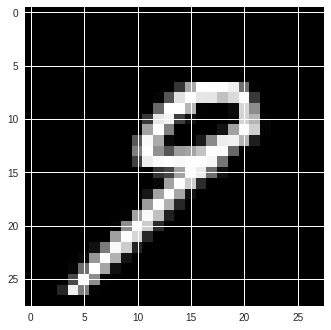

In [6]:
# Now let's see the training MNIST data as Tensors.
mnist_example = tfe.Iterator(mnist_problem.dataset(Modes.TRAIN, data_dir)).next()
image = mnist_example["inputs"]
label = mnist_example["targets"]

plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
print("Label: %d" % label.numpy())

# Translate from English to German with a pre-trained model

In [7]:
# Fetch the problem
ende_problem = problems.problem("translate_ende_wmt32k")

# Copy the vocab file locally so we can encode inputs and decode model outputs
# All vocabs are stored on GCS
vocab_file = os.path.join(gs_data_dir, "vocab.ende.32768")
!gsutil cp {vocab_file} {data_dir}

# Get the encoders from the problem
encoders = ende_problem.feature_encoders(data_dir)

# Setup helper functions for encoding and decoding
def encode(input_str, output_str=None):
  """Input str to features dict, ready for inference"""
  inputs = encoders["inputs"].encode(input_str) + [1]  # add EOS id
  batch_inputs = tf.reshape(inputs, [1, -1, 1])  # Make it 3D.
  return {"inputs": batch_inputs}

def decode(integers):
  """List of ints to str"""
  integers = list(np.squeeze(integers))
  if 1 in integers:
    integers = integers[:integers.index(1)]
  return encoders["inputs"].decode(np.squeeze(integers))

Copying gs://tensor2tensor-data/vocab.ende.32768...
/ [1 files][316.4 KiB/316.4 KiB]                                                
Operation completed over 1 objects/316.4 KiB.                                    


In [8]:
# # Generate and view the data
# # This cell is commented out because WMT data generation can take hours

# ende_problem.generate_data(data_dir, tmp_dir)
# example = tfe.Iterator(ende_problem.dataset(Modes.TRAIN, data_dir)).next()
# inputs = [int(x) for x in example["inputs"].numpy()] # Cast to ints.
# targets = [int(x) for x in example["targets"].numpy()] # Cast to ints.



# # Example inputs as int-tensor.
# print("Inputs, encoded:")
# print(inputs)
# print("Inputs, decoded:")
# # Example inputs as a sentence.
# print(decode(inputs))
# # Example targets as int-tensor.
# print("Targets, encoded:")
# print(targets)
# # Example targets as a sentence.
# print("Targets, decoded:")
# print(decode(targets))

In [9]:
# There are many models available in Tensor2Tensor
registry.list_models()

['aligned',
 'attention_lm',
 'attention_lm_moe',
 'basic_fc_relu',
 'byte_net',
 'cycle_gan',
 'diagonal_neural_gpu',
 'gene_expression_conv',
 'imagetransformer',
 'imagetransformer2d',
 'imagetransformer_moe',
 'img2img_transformer',
 'lstm_encoder',
 'lstm_seq2seq',
 'lstm_seq2seq_attention',
 'lstm_seq2seq_attention_bidirectional_encoder',
 'lstm_seq2seq_bidirectional_encoder',
 'multi_model',
 'neural_gpu',
 'resnet',
 'revnet',
 'shake_shake',
 'slice_net',
 'super_lm',
 'transformer',
 'transformer_ae',
 'transformer_encoder',
 'transformer_moe',
 'transformer_revnet',
 'transformer_sketch',
 'vanilla_gan',
 'xception']

In [10]:
# Create hparams and the model
model_name = "transformer"
hparams_set = "transformer_base"

hparams = trainer_lib.create_hparams(hparams_set, data_dir=data_dir, problem_name="translate_ende_wmt32k")

# NOTE: Only create the model once when restoring from a checkpoint; it's a
# Layer and so subsequent instantiations will have different variable scopes
# that will not match the checkpoint.
translate_model = registry.model(model_name)(hparams, Modes.EVAL)

INFO:tensorflow:Setting T2TModel mode to 'eval'
INFO:tensorflow:Setting hparams.layer_prepostprocess_dropout to 0.0
INFO:tensorflow:Setting hparams.symbol_dropout to 0.0
INFO:tensorflow:Setting hparams.attention_dropout to 0.0
INFO:tensorflow:Setting hparams.dropout to 0.0
INFO:tensorflow:Setting hparams.relu_dropout to 0.0


In [11]:
# Copy the pretrained checkpoint locally
ckpt_name = "transformer_ende_test"
gs_ckpt = os.path.join(gs_ckpt_dir, ckpt_name)
!gsutil -q cp -R {gs_ckpt} {checkpoint_dir}
ckpt_path = tf.train.latest_checkpoint(os.path.join(checkpoint_dir, ckpt_name))
ckpt_path

u'/content/t2t/checkpoints/transformer_ende_test/averaged.ckpt-0'

In [12]:
# Restore and translate!
def translate(inputs):
  encoded_inputs = encode(inputs)
  with tfe.restore_variables_on_create(ckpt_path):
    model_output = translate_model.infer(encoded_inputs)["outputs"]
  return decode(model_output)

inputs = "The animal didn't cross the street because it was too tired"
outputs = translate(inputs)

print("Inputs: %s" % inputs)
print("Outputs: %s" % outputs)

INFO:tensorflow:Greedy Decoding
Inputs: The animal didn't cross the street because it was too tired
Outputs: Die Animal-Alto-Tote-Uniform wurde too too too too too too.


## Attention Viz Utils

In [13]:
from tensor2tensor.visualization import attention
from tensor2tensor.data_generators import text_encoder

SIZE = 35

def encode_eval(input_str, output_str):
  inputs = tf.reshape(encoders["inputs"].encode(input_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  outputs = tf.reshape(encoders["inputs"].encode(output_str) + [1], [1, -1, 1, 1])  # Make it 3D.
  return {"inputs": inputs, "targets": outputs}

def get_att_mats():
  enc_atts = []
  dec_atts = []
  encdec_atts = []

  for i in range(hparams.num_hidden_layers):
    enc_att = translate_model.attention_weights[
      "transformer/body/encoder/layer_%i/self_attention/multihead_attention/dot_product_attention" % i][0]
    dec_att = translate_model.attention_weights[
      "transformer/body/decoder/layer_%i/self_attention/multihead_attention/dot_product_attention" % i][0]
    encdec_att = translate_model.attention_weights[
      "transformer/body/decoder/layer_%i/encdec_attention/multihead_attention/dot_product_attention" % i][0]
    enc_atts.append(resize(enc_att))
    dec_atts.append(resize(dec_att))
    encdec_atts.append(resize(encdec_att))
  return enc_atts, dec_atts, encdec_atts

def resize(np_mat):
  # Sum across heads
  np_mat = np_mat[:, :SIZE, :SIZE]
  row_sums = np.sum(np_mat, axis=0)
  # Normalize
  layer_mat = np_mat / row_sums[np.newaxis, :]
  lsh = layer_mat.shape
  # Add extra dim for viz code to work.
  layer_mat = np.reshape(layer_mat, (1, lsh[0], lsh[1], lsh[2]))
  return layer_mat

def to_tokens(ids):
  ids = np.squeeze(ids)
  subtokenizer = hparams.problems[0].vocabulary['targets']
  tokens = []
  for _id in ids:
    if _id == 0:
      tokens.append('<PAD>')
    elif _id == 1:
      tokens.append('<EOS>')
    elif _id == -1:
      tokens.append('<NULL>')
    else:
        tokens.append(subtokenizer._subtoken_id_to_subtoken_string(_id))
  return tokens

In [14]:
def call_html():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/3.5.8/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

## Display Attention

In [15]:
# Convert inputs and outputs to subwords
inp_text = to_tokens(encoders["inputs"].encode(inputs))
out_text = to_tokens(encoders["inputs"].encode(outputs))

# Run eval to collect attention weights
example = encode_eval(inputs, outputs)
with tfe.restore_variables_on_create(ckpt_path):
  translate_model.set_mode(Modes.EVAL)
  translate_model(example)
# Get normalized attention weights for each layer
enc_atts, dec_atts, encdec_atts = get_att_mats()

call_html()
attention.show(inp_text, out_text, enc_atts, dec_atts, encdec_atts)

INFO:tensorflow:Using variable initializer: uniform_unit_scaling
INFO:tensorflow:Transforming feature 'inputs' with symbol_modality_33708_512.bottom
INFO:tensorflow:Transforming 'targets' with symbol_modality_33708_512.targets_bottom
INFO:tensorflow:Building model body
INFO:tensorflow:Transforming body output with symbol_modality_33708_512.top
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Train a custom model on MNIST

In [16]:
# Create your own model

class MySimpleModel(t2t_model.T2TModel):

  def body(self, features):
    inputs = features["inputs"]
    filters = self.hparams.hidden_size
    h1 = tf.layers.conv2d(inputs, filters,
                          kernel_size=(5, 5), strides=(2, 2))
    h2 = tf.layers.conv2d(tf.nn.relu(h1), filters,
                          kernel_size=(5, 5), strides=(2, 2))
    return tf.layers.conv2d(tf.nn.relu(h2), filters,
                            kernel_size=(3, 3))

hparams = trainer_lib.create_hparams("basic_1", data_dir=data_dir, problem_name="image_mnist")
hparams.hidden_size = 64
model = MySimpleModel(hparams, Modes.TRAIN)

INFO:tensorflow:Setting T2TModel mode to 'train'


In [17]:
# Prepare for the training loop

# In Eager mode, opt.minimize must be passed a loss function wrapped with
# implicit_value_and_gradients
@tfe.implicit_value_and_gradients
def loss_fn(features):
  _, losses = model(features)
  return losses["training"]

# Setup the training data
BATCH_SIZE = 128
mnist_train_dataset = mnist_problem.dataset(Modes.TRAIN, data_dir)
mnist_train_dataset = mnist_train_dataset.repeat(None).batch(BATCH_SIZE)

optimizer = tf.train.AdamOptimizer()

INFO:tensorflow:Reading data files from /content/t2t/data/image_mnist-train*
INFO:tensorflow:partition: 0 num_data_files: 10


In [18]:
# Train
NUM_STEPS = 500

for count, example in enumerate(tfe.Iterator(mnist_train_dataset)):
  example["targets"] = tf.reshape(example["targets"], [BATCH_SIZE, 1, 1, 1])  # Make it 4D.
  loss, gv = loss_fn(example)
  optimizer.apply_gradients(gv)

  if count % 50 == 0:
    print("Step: %d, Loss: %.3f" % (count, loss.numpy()))
  if count >= NUM_STEPS:
    break

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Transforming feature 'inputs' with image_modality.bottom
INFO:tensorflow:Transforming 'targets' with class_label_modality_10_64.targets_bottom
INFO:tensorflow:Transforming body output with class_label_modality_10_64.top
Step: 0, Loss: 9.873
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variab

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
Step: 300, Loss: 0.395
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
Step: 350, Loss: 0.306
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

In [19]:
model.set_mode(Modes.EVAL)
mnist_eval_dataset = mnist_problem.dataset(Modes.EVAL, data_dir)

# Create eval metric accumulators for accuracy (ACC) and accuracy in
# top 5 (ACC_TOP5)
metrics_accum, metrics_result = metrics.create_eager_metrics(
    [metrics.Metrics.ACC, metrics.Metrics.ACC_TOP5])

for count, example in enumerate(tfe.Iterator(mnist_eval_dataset)):
  if count >= 200:
    break

  # Make the inputs and targets 4D
  example["inputs"] = tf.reshape(example["inputs"], [1, 28, 28, 1])
  example["targets"] = tf.reshape(example["targets"], [1, 1, 1, 1])

  # Call the model
  predictions, _ = model(example)

  # Compute and accumulate metrics
  metrics_accum(predictions, example["targets"])

# Print out the averaged metric values on the eval data
for name, val in metrics_result().items():
  print("%s: %.2f" % (name, val))

INFO:tensorflow:Reading data files from /content/t2t/data/image_mnist-dev*
INFO:tensorflow:partition: 0 num_data_files: 1
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogona

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso

INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tensorflow:Using variable initializer: orthogonal
INFO:tenso